In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the data
df = pd.read_csv("medical_insurance.csv")

In [45]:
df_premium = df[['annual_premium']]
df.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [46]:
# Sum of annual_premium - total_claims_paid
diff_sum = (df['annual_premium'] - df['total_claims_paid']).sum()
print("Net profit of the company:", diff_sum.round(2))

Net profit of the company: -79555878.7


The company lost 79555878.7 dollar in total. Our goal is to train a model to decrease the lost and try to make money.

In [47]:
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst Few Rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
print(f"\nBasic Statistics:")
print(df.describe())

Dataset Shape: (100000, 54)

First Few Rows:
   person_id  age     sex   region urban_rural   income     education  \
0      75722   52  Female    North    Suburban  22700.0     Doctorate   
1      80185   79  Female    North       Urban  12800.0         No HS   
2      19865   68    Male    North       Rural  40700.0            HS   
3      76700   15    Male    North    Suburban  15600.0  Some College   
4      92992   53    Male  Central    Suburban  89600.0     Doctorate   

  marital_status employment_status  household_size  ...  liver_disease  \
0        Married           Retired               3  ...              0   
1        Married          Employed               3  ...              0   
2        Married           Retired               5  ...              0   
3        Married     Self-employed               5  ...              0   
4        Married     Self-employed               2  ...              0   

   arthritis mental_health proc_imaging_count  proc_surgery_count  \
0 

In [48]:
# We have many None values in alcohol_freq. Beacause some customers never drink alcohol, they fill this values with 'None'
# We change all None values to 'Never'
df['alcohol_freq'] = df['alcohol_freq'].fillna('Never')
df[['alcohol_freq']].head()

,alcohol_freq
0,Never
1,Weekly
2,Never
3,Never
4,Daily


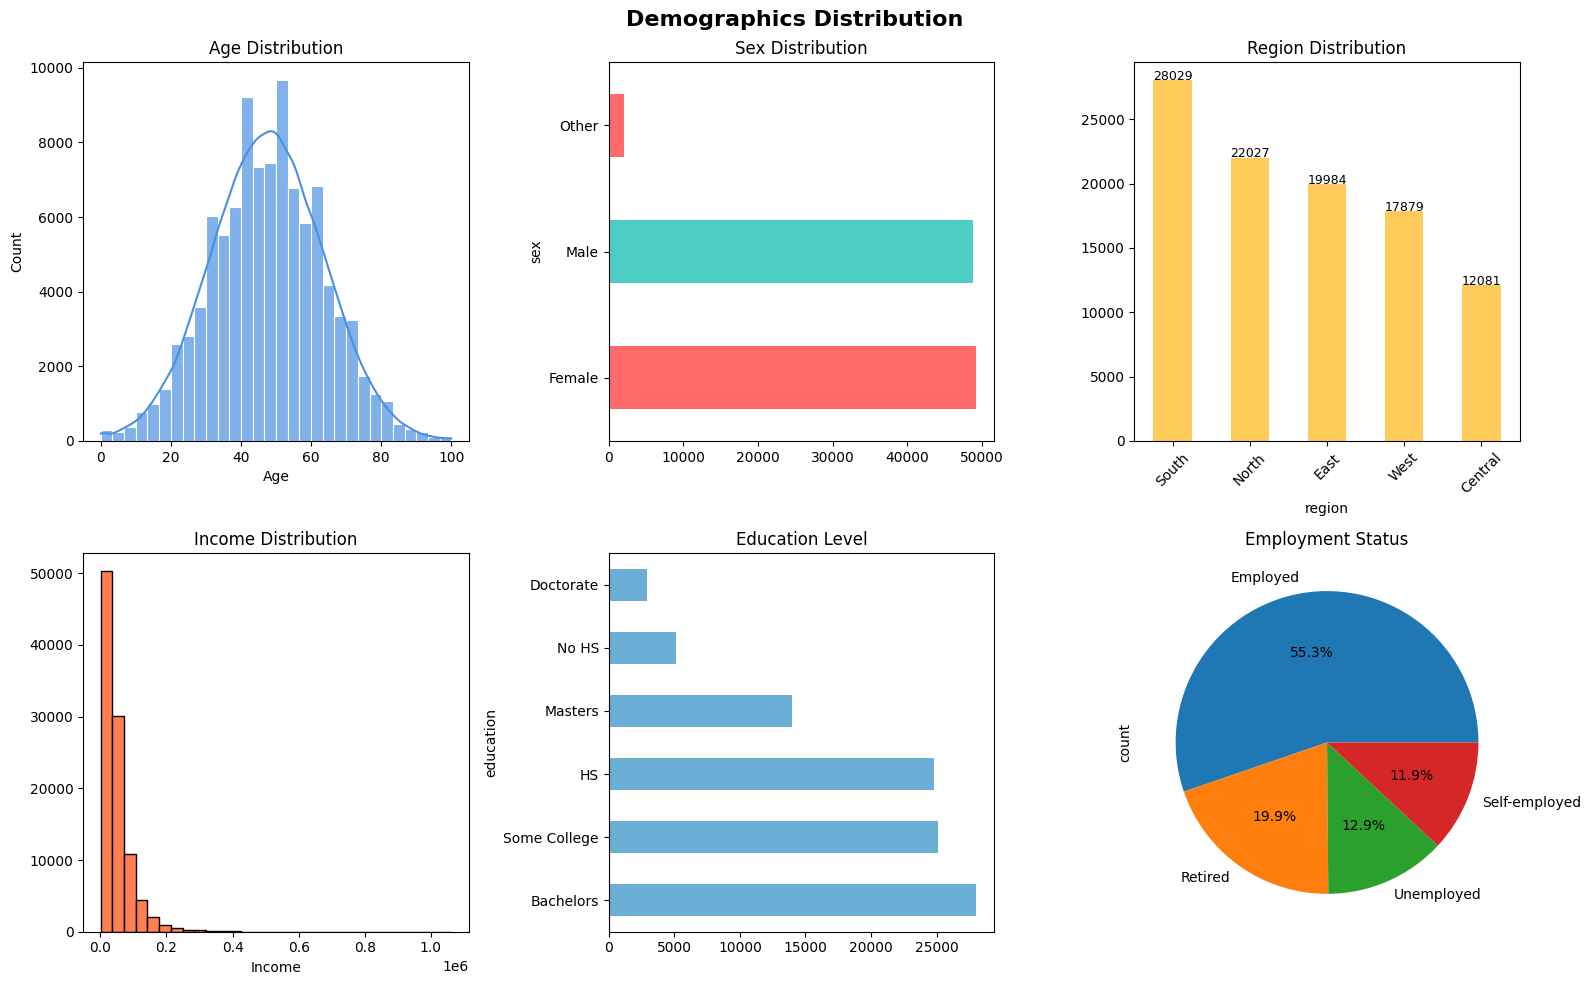

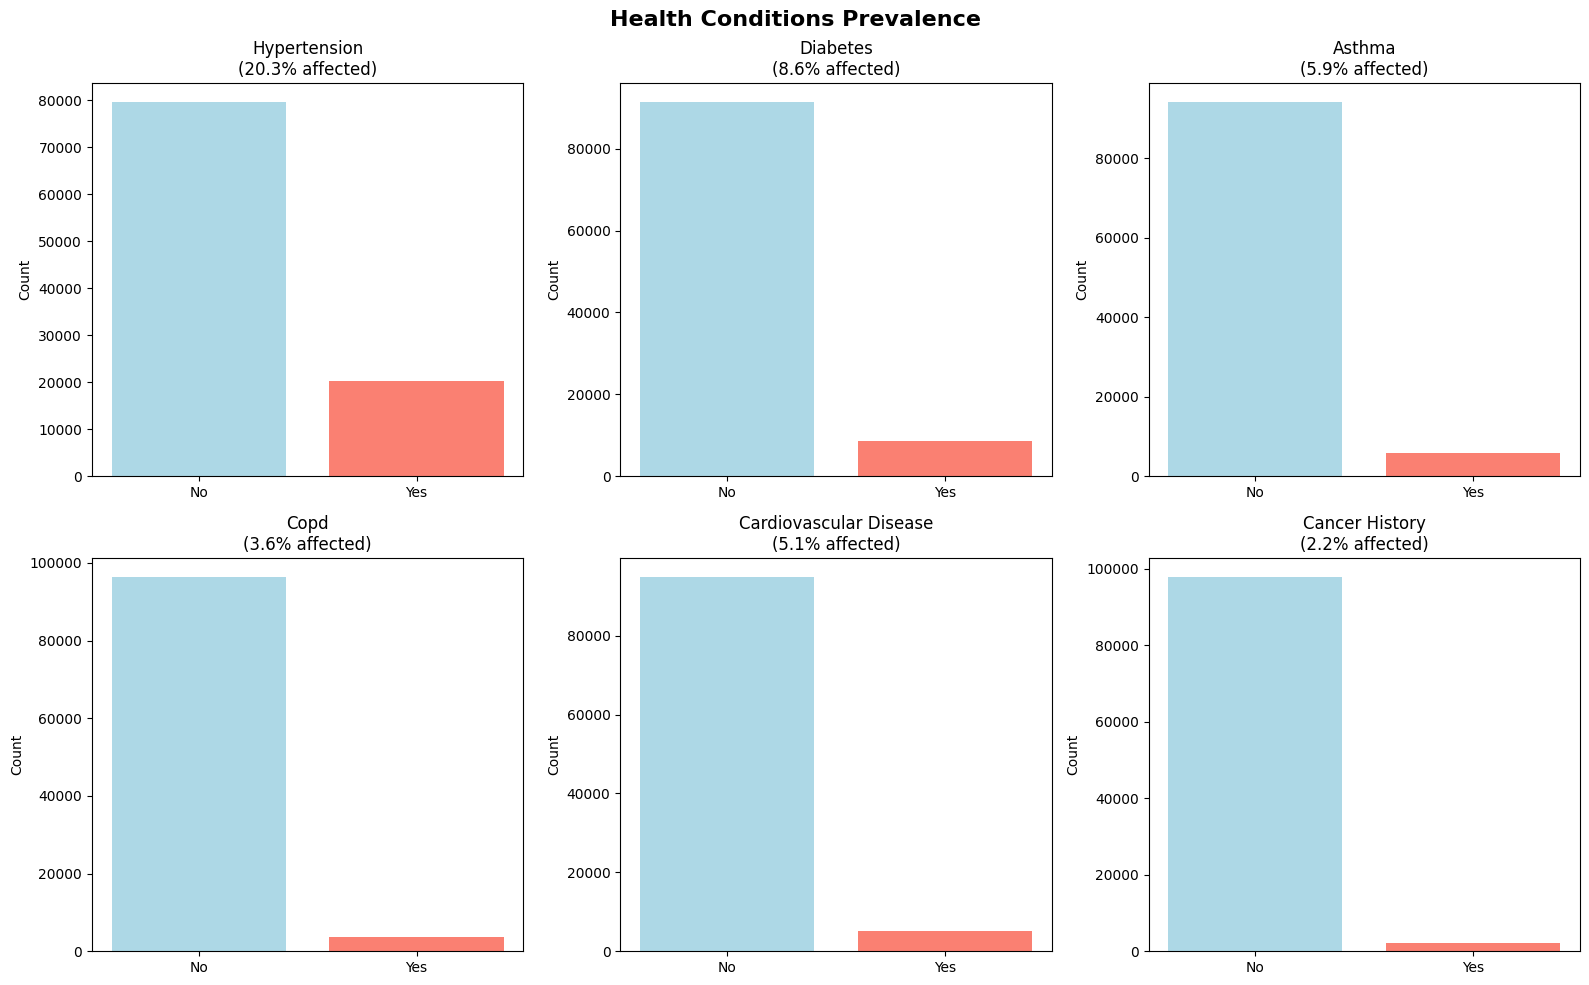

C:\Users\95354\AppData\Local\Temp\ipykernel_46136\1704832104.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1, 1].bar(['Non-Smoker', 'Smoker'], [smoker_counts.get(0, 0), smoker_counts.get(1, 0)],


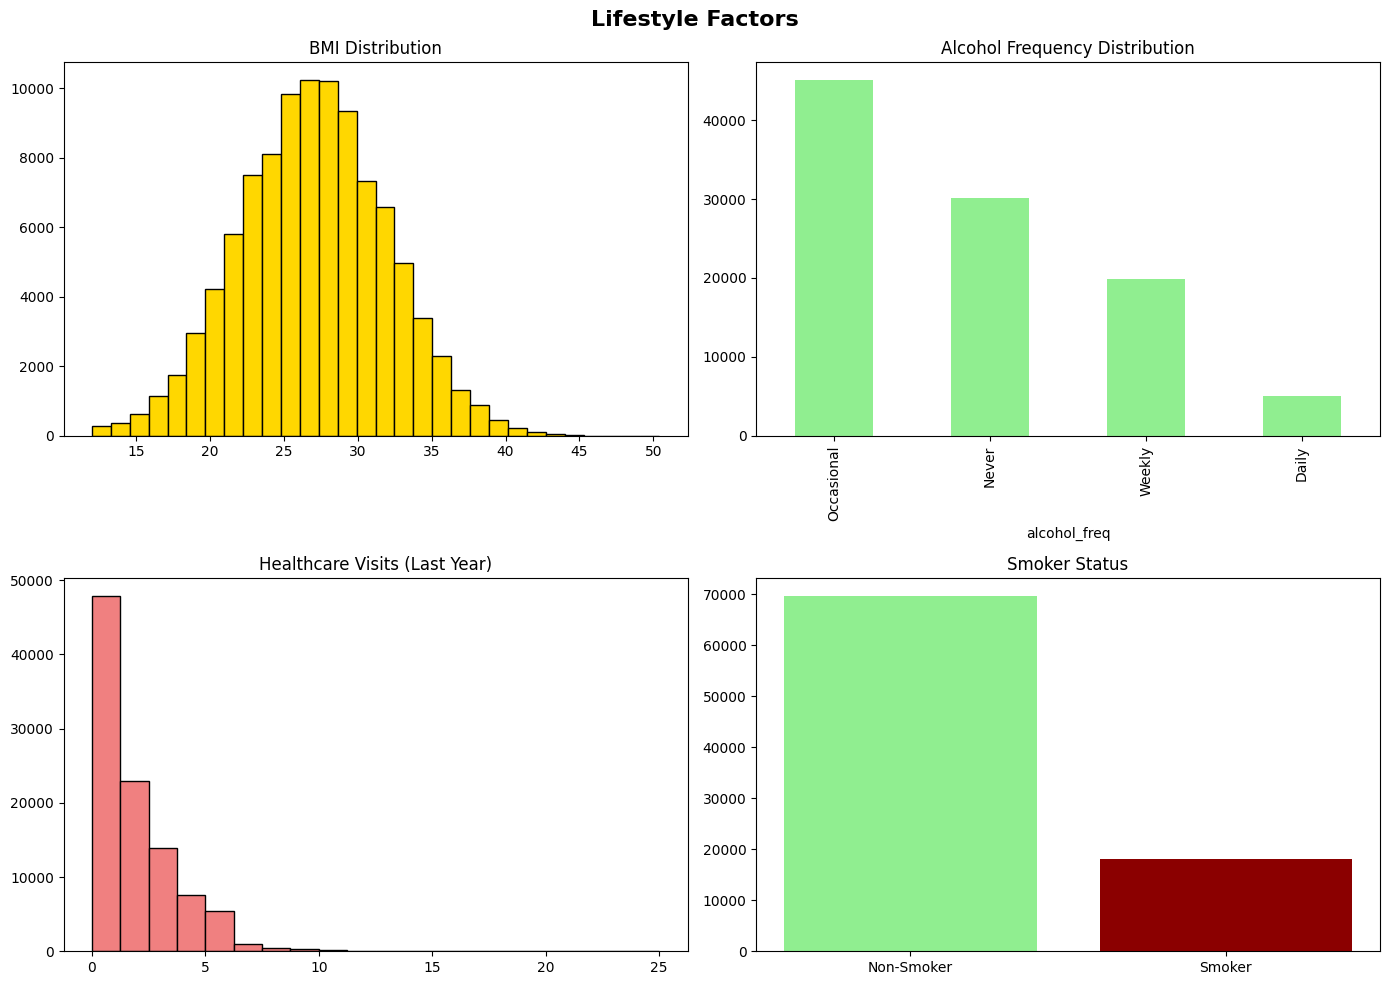

In [90]:
df_clean = df.copy()

# Demographics Distribution
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Demographics Distribution', fontsize=16, fontweight='bold')
sns.histplot(df_clean['age'], bins=30, kde=True, ax=axes[0, 0], 
             color='#4a90e2', edgecolor='white', alpha=0.7)
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
df_clean['sex'].value_counts().plot(kind='barh', ax=axes[0, 1], 
                                    color=['#ff6b6b', '#4ecdc4'])
axes[0, 1].set_title('Sex Distribution')
region_counts = df_clean['region'].value_counts()
region_counts.plot(kind='bar', ax=axes[0, 2], color='#ffcc5c')
axes[0, 2].set_title('Region Distribution')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(region_counts):
    axes[0, 2].text(i, v + 5, str(v), ha='center', fontsize=9)
axes[1, 0].hist(df_clean['income'], bins=30, color='coral', edgecolor='black')
axes[1, 0].set_title('Income Distribution')
axes[1, 0].set_xlabel('Income')
df_clean['education'].value_counts().plot(kind='barh', ax=axes[1, 1], color='#6baed6')
axes[1, 1].set_title('Education Level')
df_clean['employment_status'].value_counts().plot(kind='pie', ax=axes[1, 2], autopct='%1.1f%%')
axes[1, 2].set_title('Employment Status')

plt.tight_layout()
plt.show()

# Health Conditions
health_cols = ['hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Health Conditions Prevalence', fontsize=16, fontweight='bold')

for idx, col in enumerate(health_cols):
    ax = axes[idx // 3, idx % 3]
    counts = df_clean[col].value_counts()
    prevalence = (counts.get(1, 0) / len(df_clean) * 100) if 1 in counts.index else 0
    ax.bar(['No', 'Yes'], [counts.get(0, 0), counts.get(1, 0)], color=['lightblue', 'salmon'])
    ax.set_title(f'{col.replace("_", " ").title()}\n({prevalence:.1f}% affected)')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Lifestyle Factors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Lifestyle Factors', fontsize=16, fontweight='bold')

axes[0, 0].hist(df_clean['bmi'], bins=30, color='gold', edgecolor='black')
axes[0, 0].set_title('BMI Distribution')

# Check if alcohol_freq is numeric or categorical
if df_clean['alcohol_freq'].dtype == 'object':
    df_clean['alcohol_freq'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Alcohol Frequency Distribution')
else:
    axes[0, 1].hist(pd.to_numeric(df_clean['alcohol_freq'], errors='coerce'), bins=20, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Alcohol Frequency Distribution')

axes[1, 0].hist(df_clean['visits_last_year'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Healthcare Visits (Last Year)')

smoker_counts = df_clean['smoker'].value_counts()
axes[1, 1].bar(['Non-Smoker', 'Smoker'], [smoker_counts.get(0, 0), smoker_counts.get(1, 0)], 
               color=['lightgreen', 'darkred'])
axes[1, 1].set_title('Smoker Status')

plt.tight_layout()
plt.show()

In [49]:
# These columns are the infomation we couldnt use in our model training, we droped them
columns_to_remove = [
    'monthly_premium', 'annual_medical_cost',
   'avg_claim_amount', 'claims_count', 'person_id'
]

columns_to_remove = [col for col in columns_to_remove if col in df.columns]
df = df.drop(columns=columns_to_remove)
df.columns
df.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,...,0,1,0,1,0,2,0,1,0,0
1,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,1,...,0,1,1,0,0,1,0,1,1,0
2,68,Male,North,Rural,40700.0,HS,Married,Retired,5,3,...,0,0,1,1,0,2,1,0,1,0
3,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,...,0,0,0,1,0,0,1,0,0,0
4,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,...,0,1,0,2,0,1,1,0,1,0


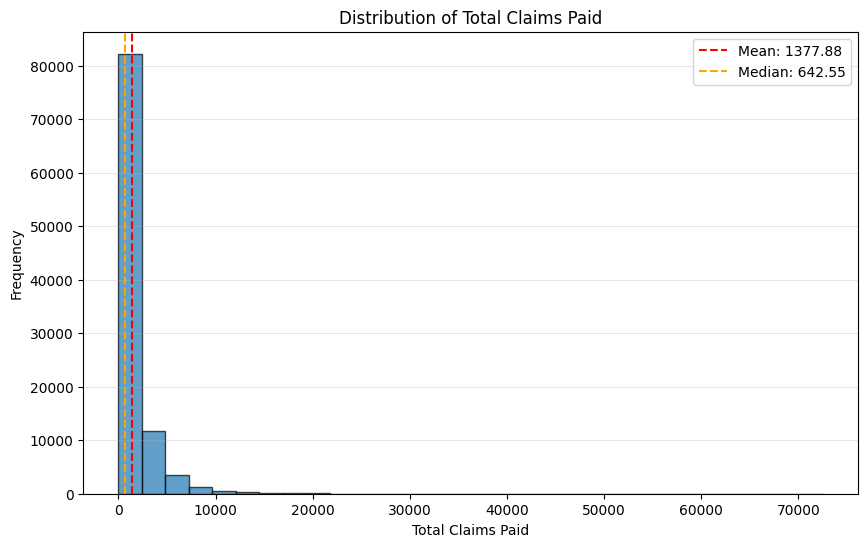

In [50]:
# Lets take a quick view about the target variable's distribution
plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(df['total_claims_paid'], 
                            bins=30, 
                            edgecolor='black', 
                            alpha=0.7)

mean_val = df['total_claims_paid'].mean()
median_val = df['total_claims_paid'].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.2f}')

plt.xlabel('Total Claims Paid')
plt.ylabel('Frequency')
plt.title('Distribution of Total Claims Paid')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [51]:
# Becaues the business type of insurance company, there will be many customers do not raise any claim during their policy
# We created a new columns to determine whether they raised claims
df['claimed'] = df['total_claims_paid'] > 0
df[['claimed']].head(10)

,claimed
0,True
1,True
2,False
3,False
4,True
5,True
6,False
7,True
8,False
9,False


In [52]:
# For model training, we need to make these variables to dummies variables
df_dummies = pd.get_dummies(df, columns=['sex','region','urban_rural','education','marital_status','employment_status',
                                         'plan_type','network_tier','deductible','copay', 'smoker', 'alcohol_freq'], drop_first=True)

print(df_dummies.head())

   age   income  household_size  dependents   bmi  visits_last_year  \
0   52  22700.0               3           1  27.4                 2   
1   79  12800.0               3           1  26.6                 2   
2   68  40700.0               5           3  31.5                 1   
3   15  15600.0               5           3  31.6                 0   
4   53  89600.0               2           0  30.5                 3   

   hospitalizations_last_3yrs  days_hospitalized_last_3yrs  medication_count  \
0                           0                            0                 4   
1                           0                            0                 3   
2                           0                            0                 4   
3                           0                            0                 1   
4                           0                            0                 2   

   systolic_bp  ...  deductible_2000  deductible_5000  copay_20  copay_30  \
0        121.0 

In [53]:
# Here, we want to train a model to predict whether a cusotmers will raise at least a claim in the futures
X = df_dummies.drop(['total_claims_paid', 'claimed', 'annual_premium'], axis=1)
y = df_dummies['claimed']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# Logistic regression should be a good tool under this task

# Logistic regression requires feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
lr_clf = LogisticRegression(random_state=42, max_iter=200)
lr_clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred_lr = lr_clf.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression AUC:", roc_auc_score(y_test, lr_clf.predict_proba(X_test_scaled)[:, 1]))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.75925
Logistic Regression AUC: 0.8703833450190356

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.75      0.70      7533
        True       0.84      0.76      0.80     12467

    accuracy                           0.76     20000
   macro avg       0.75      0.76      0.75     20000
weighted avg       0.77      0.76      0.76     20000



In [55]:
# Try a complex model to see if there is a better performance
# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    max_depth=6,        # gives us the best performance
    learning_rate=0.1,  # gives us the best performance
    n_estimators=100,   # gives us the best performance
    random_state=42,    # gives us the best performance
    n_jobs=-1
)
#
# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Predicted probabilities (for AUC)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.82365
AUC: 0.8718727356589377

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.53      0.69      7533
        True       0.78      1.00      0.88     12467

    accuracy                           0.82     20000
   macro avg       0.89      0.77      0.79     20000
weighted avg       0.86      0.82      0.81     20000



XGBoost gives better performance than Logistic regression, and it can perfectly identify which customer will not raise any claims (High quality customers). This is excectly what we want. 

In [56]:
# For the customers who raised claims, we want to investiagte the relationship between 'total_claims_paid' and other features
df_claimed = df_dummies[df_dummies['claimed'] == True].copy() # Pull out data for customers who raised claims
df_claimed.reset_index(drop=True, inplace=True)
df_claimed = df_claimed.drop(columns=['claimed'])
df_claimed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62337 entries, 0 to 62336
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              62337 non-null  int64  
 1   income                           62337 non-null  float64
 2   household_size                   62337 non-null  int64  
 3   dependents                       62337 non-null  int64  
 4   bmi                              62337 non-null  float64
 5   visits_last_year                 62337 non-null  int64  
 6   hospitalizations_last_3yrs       62337 non-null  int64  
 7   days_hospitalized_last_3yrs      62337 non-null  int64  
 8   medication_count                 62337 non-null  int64  
 9   systolic_bp                      62337 non-null  float64
 10  diastolic_bp                     62337 non-null  float64
 11  ldl                              62337 non-null  float64
 12  hba1c             

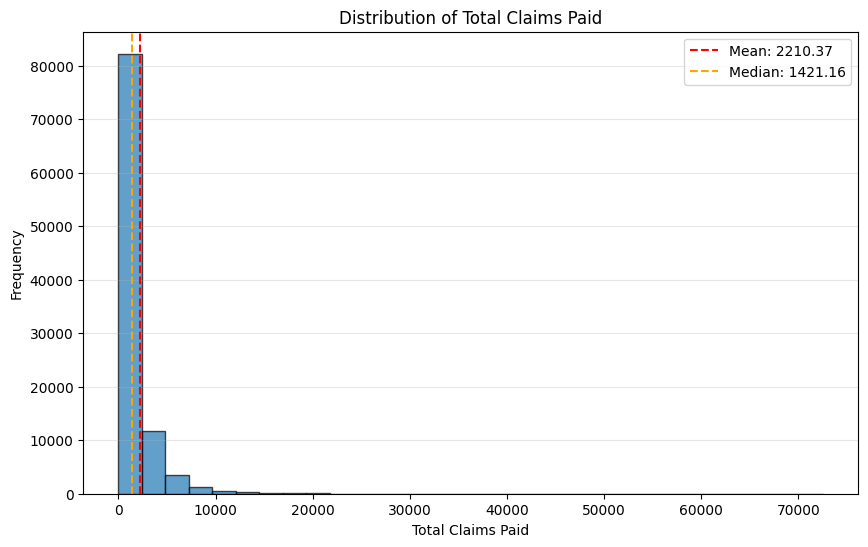

In [57]:
# Have a quick look about distribution of total_claims_paid
plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(df['total_claims_paid'], 
                            bins=30, 
                            edgecolor='black', 
                            alpha=0.7)

mean_val = df_claimed['total_claims_paid'].mean()
median_val = df_claimed['total_claims_paid'].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.2f}')

plt.xlabel('Total Claims Paid')
plt.ylabel('Frequency')
plt.title('Distribution of Total Claims Paid')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

It is a right skewness! We need to log it!

In [58]:
df_claimed['log_total_claims'] = np.log(df_claimed['total_claims_paid']) #log it

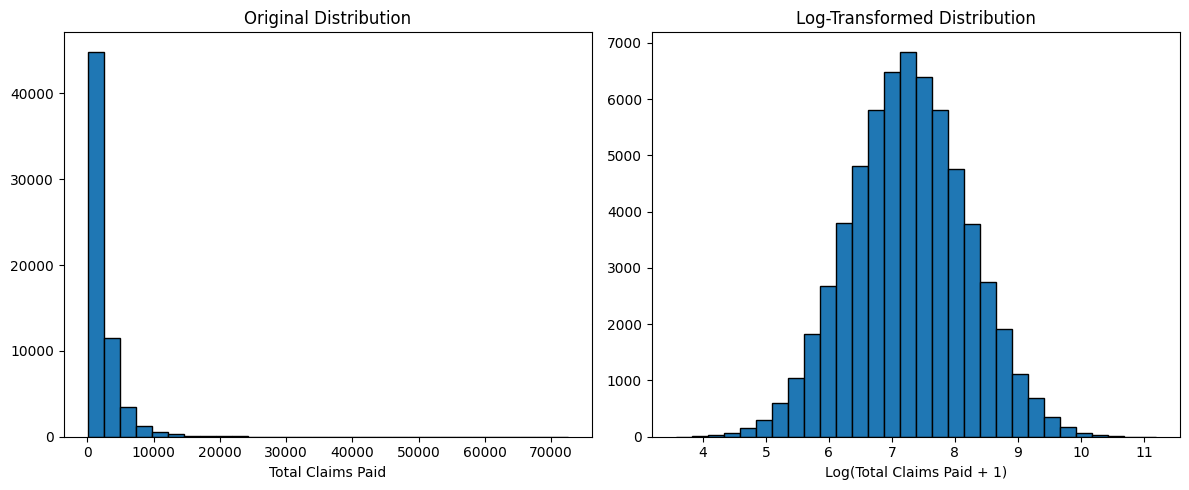

In [59]:
# Original Vs. Log

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_claimed['total_claims_paid'], bins=30, edgecolor='black')
plt.title('Original Distribution')
plt.xlabel('Total Claims Paid')

plt.subplot(1, 2, 2)
plt.hist(df_claimed['log_total_claims'], bins=30, edgecolor='black')
plt.title('Log-Transformed Distribution')
plt.xlabel('Log(Total Claims Paid + 1)')

plt.tight_layout()
plt.show()

It looks much better

In [60]:
# we dont need total_claims_paid
df_claimed = df_claimed.drop(columns=['total_claims_paid', 'annual_premium'])
df_claimed.head()

,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,deductible_5000,copay_20,copay_30,copay_50,smoker_Former,smoker_Never,alcohol_freq_Never,alcohol_freq_Occasional,alcohol_freq_Weekly,log_total_claims
0,52,22700.0,3,1,27.4,2,0,0,4,121.0,...,False,True,False,False,False,True,True,False,False,8.449469
1,79,12800.0,3,1,26.6,2,0,0,3,131.0,...,False,False,False,False,False,True,False,False,True,7.080935
2,53,89600.0,2,0,30.5,3,0,0,2,136.0,...,False,False,False,False,False,True,False,False,False,6.909993
3,63,305000.0,3,2,20.4,1,0,0,2,137.0,...,False,True,False,False,False,True,False,False,False,7.106639
4,21,83700.0,3,2,30.7,3,0,0,1,82.0,...,False,True,False,False,False,True,False,False,True,7.248547


In [61]:
# We are ready to train our model
X = df_claimed.drop('log_total_claims', axis=1)
y = df_claimed['log_total_claims']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
# Explore relationship between variables
corr_data = []
for col in X.columns:

    corr, p_value = stats.pearsonr(X[col], y)

    if abs(corr) >= 0.5:
        strength = "Strong"
    elif abs(corr) >= 0.3:
        strength = "Medium"
    elif abs(corr) >= 0.1:
        strength = "Weak"
    else:
        strength = "Very Weak"
    corr_data.append([col, round(corr, 2), round(p_value, 3), strength])


relation_table = pd.DataFrame(
    corr_data,
    columns=["Features", "correlation", "P-value", "Linear Relationship"]
).sort_values(by="correlation", ascending=False)
print(relation_table)

                       Features  correlation  P-value Linear Relationship
16                   risk_score         0.39    0.000              Medium
17                chronic_count         0.39    0.000              Medium
33                 is_high_risk         0.32    0.000              Medium
5              visits_last_year         0.31    0.000              Medium
7   days_hospitalized_last_3yrs         0.19    0.000                Weak
..                          ...          ...      ...                 ...
47       education_Some College        -0.00    0.831           Very Weak
48       marital_status_Married         0.00    0.431           Very Weak
37                  region_East        -0.01    0.061           Very Weak
61              deductible_2000        -0.01    0.093           Very Weak
67                 smoker_Never        -0.14    0.000                Weak

[71 rows x 4 columns]


In [63]:
# select features for LR
X_lr = df_claimed[['age', 'visits_last_year', 'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs', 'medication_count', 
                   'systolic_bp', 'diastolic_bp', 'hba1c', 'risk_score', 'chronic_count', 'hypertension', 'diabetes', 'arthritis', 
                   'mental_health', 'is_high_risk', 'had_major_procedure', 'smoker_Never']]
y_lr = df_claimed['log_total_claims']
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42
)

In [64]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_lr_train, y_lr_train)

coefficients = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': lr_model.coef_
})
intercept = lr_model.intercept_ 

print("Intercept: ", intercept)
print(coefficients.sort_values(by='Coefficient', ascending=False))

Intercept:  6.58294862464139
                        Feature  Coefficient
8                    risk_score     1.146030
9                 chronic_count     0.127382
3   days_hospitalized_last_3yrs     0.102678
1              visits_last_year     0.085228
2    hospitalizations_last_3yrs     0.057552
12                    arthritis     0.019778
10                 hypertension     0.018294
15          had_major_procedure     0.017127
13                mental_health     0.006430
4              medication_count     0.000633
6                  diastolic_bp     0.000586
7                         hba1c    -0.000293
5                   systolic_bp    -0.000436
11                     diabetes    -0.003714
0                           age    -0.004240
14                 is_high_risk    -0.049196
16                 smoker_Never    -0.170188


In [65]:
y_lr_train_pred = lr_model.predict(X_lr_train)
train_r2 = r2_score(y_lr_train, y_lr_train_pred)
train_mse = mean_squared_error(y_train, y_lr_train_pred)

y_lr_test_pred = lr_model.predict(X_lr_test)
test_r2 = r2_score(y_lr_test, y_lr_test_pred)
test_mse = mean_squared_error(y_lr_test, y_lr_test_pred)

print(f"Train-R²: {train_r2:.2f}, Test-R²: {test_r2:.2f}")
print(f"Train-MSE: {train_mse:.2f}, Test-MSE: {test_mse:.2f}")

Train-R²: 0.24, Test-R²: 0.26
Train-MSE: 0.66, Test-MSE: 0.65


This result isnt enough, we will try some complex model below, to see if we can have better performance

In [66]:
# we try to use Random Forest
rf_model = RandomForestRegressor(
    # Best performance and efficiency under this setting
    n_estimators=200,
    max_depth=11,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [67]:

y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)


y_test_pred = rf_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train-R²: {train_r2:.2f}, Test-R²: {test_r2:.2f}")
print(f"Train-MSE: {train_mse:.2f}, Test-MSE: {test_mse:.2f}")

Train-R²: 0.38, Test-R²: 0.25
Train-MSE: 0.54, Test-MSE: 0.65


Test-R²: 0.25 => Worse than linear regression, we will try XGBoost

In [68]:
xgb_opt = xgb.XGBRegressor(
    # Best performance and efficiency under this setting
    max_depth=6,
    learning_rate=0.08,
    n_estimators=100,
    reg_alpha=1,
    reg_lambda=1,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


xgb_opt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [69]:
y_train_pred = xgb_opt.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)


y_test_pred = xgb_opt.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train-R²: {train_r2:.2f}, Test-R²: {test_r2:.2f}")
print(f"Train-MSE: {train_mse:.2f}, Test-MSE: {test_mse:.2f}")

Train-R²: 0.31, Test-R²: 0.26
Train-MSE: 0.60, Test-MSE: 0.65


Better than Linear regression

In [74]:
# X_new = df_dummies.drop(['total_claims_paid', 'claimed'], axis=1)  # 特征
# y = df_dummies['total_claims_paid']  # 目标（True/False）

X = df_dummies.drop(['total_claims_paid', 'claimed'], axis=1)
y = df_dummies['total_claims_paid']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)
df_premium = X_test[['annual_premium']]
X_new = X_test.drop(columns='annual_premium')
y = y_test


# ----------------------
# 1. Stage 1: Predict if a customer will claim (True/False)
# ----------------------
# Predict 'claimed' using xgb_clf (no log transformation needed here)
y_pred_claimed = xgb_clf.predict(X_new)

# ----------------------
# 2. Stage 2: Predict total_claims_paid (with inverse log transformation)
# ----------------------
final_claims_pred = np.zeros(len(X_new))  # Default to 0 for non-claimants
claimed_true_indices = np.where(y_pred_claimed == True)[0]

if len(claimed_true_indices) > 0:
    X_claimed_true = X_new.iloc[claimed_true_indices]
    
    # Predict log-transformed total_claims_paid
    log_claims_pred = xgb_opt.predict(X_claimed_true)
    
    # Inverse log transformation (log1p → expm1: e^x - 1)
    original_claims_pred = np.expm1(log_claims_pred)  # Convert back to original scale
    
    # Assign to final predictions
    final_claims_pred[claimed_true_indices] = original_claims_pred

# ----------------------
# 3. Combine results
# ----------------------
results_df = pd.DataFrame({
    'customer_id': X_new.index,
    'predicted_claimed': y_pred_claimed,
    'predicted_total_claims_paid': final_claims_pred,
    'actual_total_claims_paid': y,
    'anual_premium': df_premium.values.ravel()
})

print(results_df.head(10))


       customer_id  predicted_claimed  predicted_total_claims_paid  \
75721        75721                  1                  2430.025879   
80184        80184                  1                   861.932861   
19864        19864                  1                  1543.949829   
76699        76699                  0                     0.000000   
92991        92991                  1                  2190.830811   
76434        76434                  1                  1574.839722   
84004        84004                  1                  1688.278687   
80917        80917                  0                     0.000000   
60767        60767                  1                   637.334106   
50074        50074                  1                  1224.088989   

       actual_total_claims_paid  anual_premium  
75721                    918.30         367.52  
80184                    869.56         426.43  
19864                    633.26         351.16  
76699                      0.00  

In [75]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 75721 to 42410
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  20000 non-null  int64  
 1   predicted_claimed            20000 non-null  int32  
 2   predicted_total_claims_paid  20000 non-null  float64
 3   actual_total_claims_paid     20000 non-null  float64
 4   anual_premium                20000 non-null  float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 859.4 KB


In [76]:
# Quantiative Benifit of the model:
r2 = r2_score(results_df['actual_total_claims_paid'], results_df['predicted_total_claims_paid'])
print(f"R² Score: {r2:.2f}")

R² Score: 0.32


# Quantiative Benifit of the model:

In [ ]:
# Before we have this model, the company will make profit:
sum_diff_original = (results_df['anual_premium'] - results_df['actual_total_claims_paid']).sum()
print("Sum of anual_premium - actual_total_claims_paid: ", sum_diff_original.round(2))

Sum of anual_premium - actual_total_claims_paid:  -15582597.8


The Company will loss 15582597.8 dollar under these 20000 transactions

In [77]:
# For risk control, we only accept transactions where predicted_total_claims_paid ≤ annual_premium, as these are likely profitable.
filtered_rows = results_df[results_df['predicted_total_claims_paid'] <= results_df['anual_premium']]
filtered_rows.head()

,customer_id,predicted_claimed,predicted_total_claims_paid,actual_total_claims_paid,anual_premium
76699,76699,0,0.0,0.0,368.70
80917,80917,0,0.0,0.0,288.54
27701,27701,0,0.0,0.0,436.39
42141,42141,0,0.0,0.0,267.17
29130,29130,0,0.0,0.0,393.23


In [78]:
filtered_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4502 entries, 76699 to 37862
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  4502 non-null   int64  
 1   predicted_claimed            4502 non-null   int32  
 2   predicted_total_claims_paid  4502 non-null   float64
 3   actual_total_claims_paid     4502 non-null   float64
 4   anual_premium                4502 non-null   float64
dtypes: float64(3), int32(1), int64(1)
memory usage: 193.4 KB


In [79]:
# What the profit we make under this stratgy:
sum_diff_result = (filtered_rows['anual_premium'] - filtered_rows['actual_total_claims_paid']).sum()
print("Sum of anual_premium - actual_total_claims_paid: ", sum_diff_result.round(2))

Sum of anual_premium - actual_total_claims_paid:  657760.26


With our model and stratage, after refusing some high risk cusotmers, will make 657760.26 dollar profit in total

In [87]:
model_value = sum_diff_result-sum_diff_original
print(f'Value of this model: 657760.26 - (-15582597.8) = {model_value}')

Value of this model: 657760.26 - (-15582597.8) = 16240358.06


What we will earn if the model is perfect (Max revenue):

In [85]:
filtered_rows_2 = results_df[results_df['actual_total_claims_paid'] <= results_df['anual_premium']]
filtered_rows.head()

,customer_id,predicted_claimed,predicted_total_claims_paid,actual_total_claims_paid,anual_premium
76699,76699,0,0.0,0.0,368.70
80917,80917,0,0.0,0.0,288.54
27701,27701,0,0.0,0.0,436.39
42141,42141,0,0.0,0.0,267.17
29130,29130,0,0.0,0.0,393.23


In [86]:
sum_diff = (filtered_rows_2['anual_premium'] - filtered_rows_2['actual_total_claims_paid']).sum()
print("anual_premium - actual_total_claims_paid: ", sum_diff)

anual_premium - actual_total_claims_paid:  4126096.64


In [89]:
# Gap between the best case:
print(f'Gap between the best case: {sum_diff-sum_diff_result}')

# Persetage we acheived:
print(f'persentage we achieved: {(sum_diff_result/sum_diff*100).round(2)}%')

Gap between the best case: 3468336.38
persentage we achieved: 15.94%
